In [1]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from PIL import Image
import Metrics
import matplotlib.pyplot as plt

In [85]:
def encode_img_jpeg(img,x):
  img = tf.convert_to_tensor(img, dtype=tf.uint8)
  print(img)
  img = tf.io.encode_jpeg(img, format='rgb')
  img = tf.image.resize(img, [x, x])
  return img


In [81]:
(_, _), (test_images, _) = datasets.cifar10.load_data()
test_images = test_images[:10000]
# test_images = test_images.astype('float32') / 255.0
img_size = test_images.shape[1:]
print(test_images[0])

[[[158 112  49]
  [159 111  47]
  [165 116  51]
  ...
  [137  95  36]
  [126  91  36]
  [116  85  33]]

 [[152 112  51]
  [151 110  40]
  [159 114  45]
  ...
  [136  95  31]
  [125  91  32]
  [119  88  34]]

 [[151 110  47]
  [151 109  33]
  [158 111  36]
  ...
  [139  98  34]
  [130  95  34]
  [120  89  33]]

 ...

 [[ 68 124 177]
  [ 42 100 148]
  [ 31  88 137]
  ...
  [ 38  97 146]
  [ 13  64 108]
  [ 40  85 127]]

 [[ 61 116 168]
  [ 49 102 148]
  [ 35  85 132]
  ...
  [ 26  82 130]
  [ 29  82 126]
  [ 20  64 107]]

 [[ 54 107 160]
  [ 56 105 149]
  [ 45  89 132]
  ...
  [ 24  77 124]
  [ 34  84 129]
  [ 21  67 110]]]


In [52]:
SNR = 20
x = 16
k = x**2*3
n = np.prod(img_size)
k_n = k/n

decode_img = []

In [91]:
img_pil = Image.fromarray(test_images[0].astype('uint8'))

img_pil.save('j.jpeg', format='JPEG', quality=0)

In [86]:
encode_img = encode_img_jpeg(test_images[0], x)

print(encode_img.numpy())

tf.Tensor(
[[[158 112  49]
  [159 111  47]
  [165 116  51]
  ...
  [137  95  36]
  [126  91  36]
  [116  85  33]]

 [[152 112  51]
  [151 110  40]
  [159 114  45]
  ...
  [136  95  31]
  [125  91  32]
  [119  88  34]]

 [[151 110  47]
  [151 109  33]
  [158 111  36]
  ...
  [139  98  34]
  [130  95  34]
  [120  89  33]]

 ...

 [[ 68 124 177]
  [ 42 100 148]
  [ 31  88 137]
  ...
  [ 38  97 146]
  [ 13  64 108]
  [ 40  85 127]]

 [[ 61 116 168]
  [ 49 102 148]
  [ 35  85 132]
  ...
  [ 26  82 130]
  [ 29  82 126]
  [ 20  64 107]]

 [[ 54 107 160]
  [ 56 105 149]
  [ 45  89 132]
  ...
  [ 24  77 124]
  [ 34  84 129]
  [ 21  67 110]]], shape=(32, 32, 3), dtype=uint8)


ValueError: 'images' must have either 3 or 4 dimensions.

In [55]:
for test_image in test_images:
  encode_img.append(encode_img_jpeg(test_image, x))

ValueError: Tensor conversion requested dtype string for Tensor with dtype uint8: <tf.Tensor: shape=(32, 32, 3), dtype=uint8, numpy=
array([[[158, 112,  49],
        [159, 111,  47],
        [165, 116,  51],
        ...,
        [137,  95,  36],
        [126,  91,  36],
        [116,  85,  33]],

       [[152, 112,  51],
        [151, 110,  40],
        [159, 114,  45],
        ...,
        [136,  95,  31],
        [125,  91,  32],
        [119,  88,  34]],

       [[151, 110,  47],
        [151, 109,  33],
        [158, 111,  36],
        ...,
        [139,  98,  34],
        [130,  95,  34],
        [120,  89,  33]],

       ...,

       [[ 68, 124, 177],
        [ 42, 100, 148],
        [ 31,  88, 137],
        ...,
        [ 38,  97, 146],
        [ 13,  64, 108],
        [ 40,  85, 127]],

       [[ 61, 116, 168],
        [ 49, 102, 148],
        [ 35,  85, 132],
        ...,
        [ 26,  82, 130],
        [ 29,  82, 126],
        [ 20,  64, 107]],

       [[ 54, 107, 160],
        [ 56, 105, 149],
        [ 45,  89, 132],
        ...,
        [ 24,  77, 124],
        [ 34,  84, 129],
        [ 21,  67, 110]]], dtype=uint8)>

In [8]:
tf.print(Metrics.PSNR(train_images[0], train_images[1]))

10.0594463


In [3]:
(_, _), (test_images, _) = datasets.cifar10.load_data()
test_images = test_images[:10000]
img_size = test_images.shape[1:]

In [24]:
SNR = 20
P = 1
N = P/10**(SNR/10)
C = np.log2(1+SNR)
x = 20
k = x**2*3
n = np.prod(img_size)
k_n = k/n
R_max = k/n*C
R = R_max
if R > 1:
  Q = 0.5*R
else:
  Q=1-0.5/R
Q = int(Q*100)
print(N)
print(R_max)
print(Q)
print(k_n)

0.01
1.7157489932729535
85
0.390625


In [29]:
def compress_image(image, quality):
  # image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
  encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
  result, encimg = cv2.imencode('.jpeg', image, encode_param)
  if not result:
    print('could not encode image!')
    return None
  decimg = cv2.imdecode(encimg, 1)
  # decimg = cv2.imdecode(encimg, cv2.IMREAD_COLOR)
  # decimg = cv2.cvtColor(decimg, cv2.COLOR_BGR2RGB)
  return decimg

In [30]:
PSNR = []
for test_image in test_images:
  decode_img = compress_image(test_image, Q)
  decode_img = decode_img/255.0
  # print(np.mean(decode_img))
  P = np.mean(decode_img)
  N = P/10**(SNR/10)
  # noise = np.random.normal(0, np.sqrt(N), decode_img.shape)
  # print(noise)
  # decode_img = decode_img + noise
  # decode_img[decode_img > 1] = 1
  # decode_img[decode_img < 0] = 0
  test_image = test_image/255.0
  PSNR.append(Metrics.PSNR(decode_img, test_image))

In [31]:
PSNR_avg = sum(PSNR)/len(PSNR)
print(PSNR_avg)

tf.Tensor(32.246025, shape=(), dtype=float32)


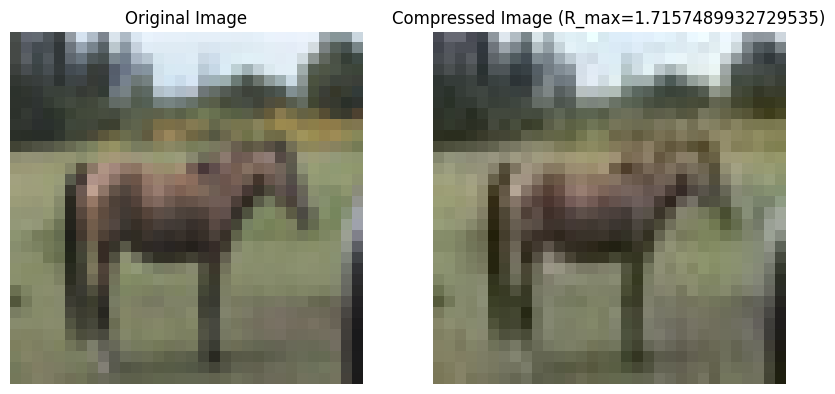

In [32]:
# 結果の表示
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(test_images[9999])
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(decode_img)
axes[1].set_title(f'Compressed Image (R_max={R_max})')
axes[1].axis('off')

plt.show()

In [77]:
decode_img = decode_img/255.0
test_image = test_images[0]/255.0

tf.print(Metrics.PSNR(decode_img, test_images[0]))

30.5848961


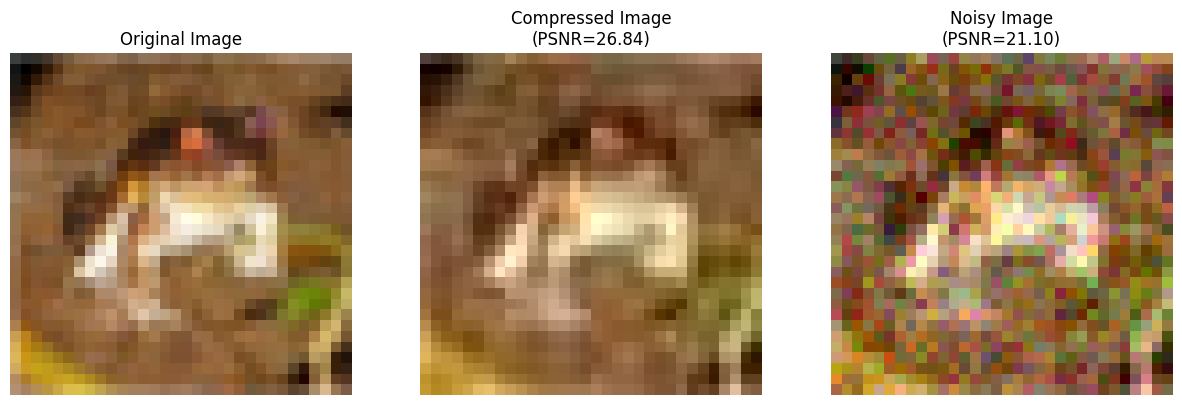

In [53]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from skimage.metrics import peak_signal_noise_ratio as psnr

# CIFAR-10データセットの読み込み
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# 最初の画像を取得
original_image = x_train[0]

# JPEGで圧縮
def compress_image(image, quality):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
    is_success, encimg = cv2.imencode('.jpg', image, encode_param)
    if not is_success:
        print('could not encode image!')
        return None
    decimg = cv2.imdecode(encimg, cv2.IMREAD_COLOR)
    decimg = cv2.cvtColor(decimg, cv2.COLOR_BGR2RGB)
    return decimg

# AWGNノイズを追加
def add_awgn_noise(image, noise_std_dev):
    row, col, ch = image.shape
    mean = 0
    gauss = np.random.normal(mean, noise_std_dev, (row, col, ch))
    noisy = image + gauss
    noisy = np.clip(noisy, 0, 255)
    return noisy.astype(np.uint8)

# PSNRを計算
def calculate_psnr(original, compressed):
    return psnr(original, compressed, data_range=255)

# 圧縮レートを指定
quality = 50  # 圧縮レートを指定 (例: 50)
compressed_image = compress_image(original_image, quality)

# ノイズの標準偏差を指定してノイズを追加
noise_std_dev = 20
noisy_image = add_awgn_noise(compressed_image, noise_std_dev)

# PSNRの計算
psnr_compressed = calculate_psnr(original_image, compressed_image)
psnr_noisy = calculate_psnr(original_image, noisy_image)

# 結果の表示
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(compressed_image)
axes[1].set_title(f'Compressed Image\n(PSNR={psnr_compressed:.2f})')
axes[1].axis('off')

axes[2].imshow(noisy_image)
axes[2].set_title(f'Noisy Image\n(PSNR={psnr_noisy:.2f})')
axes[2].axis('off')

plt.show()
